## Rewrite
So what we really want is to minise all 4 independantly. I cant think of a good loss funciton for that so Im going to run 4 minimisations and pick the best.

In [11]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import struct

In [12]:
#layer = np.array([0,1,2,3,4,5,6,7])
#wire = np.array([2,2,2,2,2,2,2,2])
#tdc = np.array([9,190,59,121,129,51,198,17])

DIVIDER = 1000

In [13]:
def conv_hit_to_coords(l : np.array, w : np.array):
    # if l is odd, add 0.5 to it
    x = l
    y = w+ 0.5*(l%2)
    return (x, y)

def get_basic_plot(ev):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    for i in range(8):
        for j in range(8):
            x, y = conv_hit_to_coords(i,j)
            ax.plot(x, y, 'k.')

    x, y = conv_hit_to_coords(ev.layer, ev.wire)
    ax.plot(x, y, 'rx')
    ax.set(xlabel='Layer', ylabel='Wire',)
    return ax

def plot_TDC_circles(ax, ev, v=1):
    
    for i in range(8):
        x, y = conv_hit_to_coords(ev.layer[i], ev.wire[i])
        ax.add_artist(plt.Circle((x,y), ev.tdc[i] / DIVIDER * v, color='b', fill=False))
    
    return ax


In [14]:
# ax + bY + c = 0
class line:
    def __init__(self, a , b, c):
        self.a = a
        self.b = b
        self.c = c
    
    def plot(self, ax, xmin, xmax):
        x = np.linspace(xmin, xmax, 100)
        y = (-self.a * x - self.c) / self.b
        ax.plot(x, y)
        return ax

class circle:
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
    
    def plot(self, ax):
        ax.add_artist(plt.Circle((self.x, self.y), self.r, color='b', fill=False))
        return ax


def get_tangents_to_two_circles(c1, c2):
    ls = []

    # four solutions
    for i in [-1, 1]:
        for j in [-1, 1]:
            r1 = c1.r * i
            r2 = c2.r * j

            dr = r2 - r1

            x = c2.x - c1.x
            y = c2.y - c1.y

            z = x**2 + y**2
            d = np.sqrt( np.abs(z - dr**2) )

            a = (x * dr + y*d)/z
            b = (y * dr - x*d)/z
            c = r1 - c1.x * a - c1.y * b

            l = line(a, b, c)  
            ls.append(l) 

    return ls

# slightly faster than get_tangents to two circles
# (when written in c)
def get_nth_tangents_to_two_circles(c1, c2, n):
    
    if n == 0:
        i = 1
        j = 1
    
    elif n == 1:
        i = 1
        j = -1
    
    elif n== 2:
        i = -1
        j = 1
    
    else:
        i = -1
        j = -1

    # four solutions

    r1 = c1.r * i
    r2 = c2.r * j

    dr = r2 - r1

    x = c2.x - c1.x
    y = c2.y - c1.y

    z = x**2 + y**2
    d = np.sqrt( np.abs(z - dr**2) )

    a = (x * dr + y*d)/z
    b = (y * dr - x*d)/z
    c = r1 - c1.x * a - c1.y * b

    l = line(a, b, c)  

    return l

def circle_line_dist(ev, l : line, v : float, c1_num : float, c2_num : float) -> float:
    # return the total distance to the line from the 6 other circles
    total_distance = 0.
    for i in range(8):
        if (i != c1_num) or (i != c2_num):
            ci_coords = conv_hit_to_coords(ev.layer[i], ev.wire[i])
            ci = circle(ci_coords[0], ci_coords[1], ev.tdc[i] / DIVIDER * v)
            total_distance += np.abs(l.a * ci.x + l.b * ci.y + l.c) / np.sqrt(l.a**2 + l.b**2)

    return total_distance

def largest_circles(ev):
    return np.argmax(ev.tdc), np.argmax(ev.tdc[ev.tdc != np.max(ev.tdc)])

In [15]:
class event:
    def __init__(self, ith, fname='../data/manytracks.raw'):
        self.ith = ith
        self.fname = fname
        self.layer = []
        self.wire = []
        self.tdc = []
        self.best_v = 0
        self.best_v_tangent_number = 5

        # load the ith event
        with open(fname, 'rb') as file:

            file.seek(ith*16)
            event_data = file.read(16)
            data = list(event_data)
            if not event_data:
                return

            # Process each hit (2 bytes per hit, 8 hits per event)
            for i in range(8):
                hit_data = event_data[i*2:(i+1)*2]
                if len(hit_data) < 2:
                    continue  # Skip incomplete data

                # Unpack the 16-bit datum (little-endian)
                datum = struct.unpack('<H', hit_data)[0]

                # Extract the layer number (lowest 3 bits)
                layer_number = datum & 0b111

                # Extract the wire number (next 3 bits)
                wire_number = (datum >> 3) & 0b111

                # Extract the TDC count (remaining 10 bits)
                tdc_count = (datum >> 6) & 0b1111111111

                self.layer.append(layer_number)
                self.wire.append(wire_number)
                self.tdc.append(tdc_count)
        
        self.layer = np.array(self.layer)
        self.wire = np.array(self.wire)
        self.tdc = np.array(self.tdc)
    
    def plot(self):
        ax = plot_TDC_circles(get_basic_plot(self), self, v=self.best_v)
        c1_num, c2_num = largest_circles(self)
        c1_coords = conv_hit_to_coords(self.layer[c1_num], self.wire[c1_num])
        c2_coords = conv_hit_to_coords(self.layer[c2_num], self.wire[c2_num])
        c1 = circle(c1_coords[0], c1_coords[1], self.tdc[c1_num] / DIVIDER * self.best_v)
        c2 = circle(c2_coords[0], c2_coords[1], self.tdc[c2_num] / DIVIDER * self.best_v)
        l = get_nth_tangents_to_two_circles(c1, c2, self.best_v_tangent_number)
        l.plot(ax, 0, 8)


e1 = event(0, "../data/onetrack.raw")

In [16]:
def f(v, i, c1_coords, c2_coords, tdc, i_c1, i_c2, ev):
    """
    v: velocity
    i: line tangent line number
    """

    # setup circles
    c1 = circle(c1_coords[0], c1_coords[1], tdc[i_c1] / DIVIDER * v)
    c2 = circle(c2_coords[0], c2_coords[1], tdc[i_c2] / DIVIDER * v)

    # get tangent
    l = get_nth_tangents_to_two_circles(c1, c2, i)

    return circle_line_dist(ev, l, v, 0, 1)

def dfdv():
    return 0.0


In [38]:
def run(ev : event):
    # problem setup
    i_c1, i_c2 = largest_circles(ev)

    res_arr = []

    c1_coords = conv_hit_to_coords(ev.layer[i_c1], ev.wire[i_c1])
    c2_coords = conv_hit_to_coords(ev.layer[i_c2], ev.wire[i_c2])
    for i in range(4):
        res_arr.append(minimize(f, x0=0.002, args=(i, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev))) # Might need to impliment my own gradient descent

    # find the best fit line
    best_distance = 1e99
    best_v = 0.
    for i, r in enumerate(res_arr):
        d = f(r.x, i, c1_coords, c2_coords, ev.tdc, i_c1, i_c2, ev)
        if (d < best_distance):
            best_distance = d
            best_v = r.x
            ev.best_v_tangent_number = i
        #print(r.x, d)
    ev.best_v = best_v
    #return best_v, best_distance

print(e1.best_v)
run(e1)

[2.17191301]


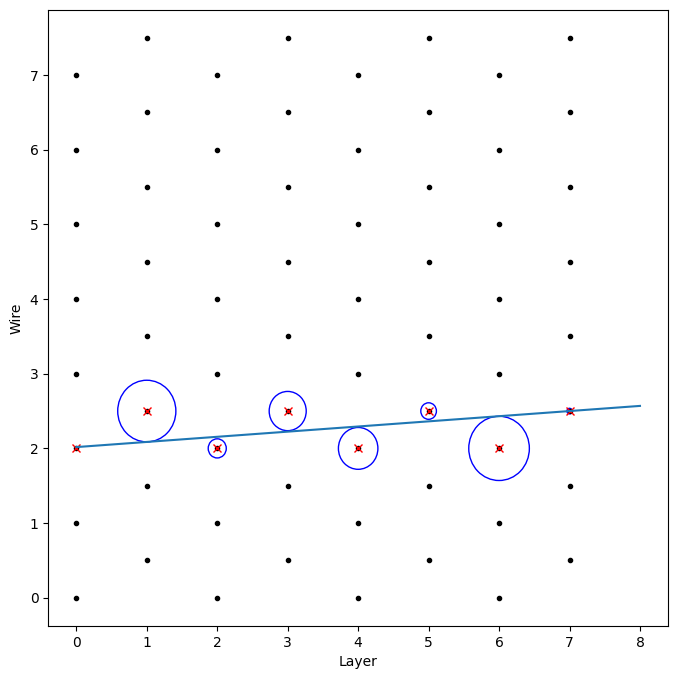

In [39]:
e1.plot()

/tmp/ipykernel_60004/920078276.py:84: RuntimeWarning: invalid value encountered in divide
  a = (x * dr + y*d)/z
/tmp/ipykernel_60004/920078276.py:85: RuntimeWarning: invalid value encountered in divide
  b = (y * dr - x*d)/z
/tmp/ipykernel_60004/920078276.py:84: RuntimeWarning: invalid value encountered in scalar divide
  a = (x * dr + y*d)/z
/tmp/ipykernel_60004/920078276.py:85: RuntimeWarning: invalid value encountered in scalar divide
  b = (y * dr - x*d)/z
/tmp/ipykernel_60004/3408393369.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,8))


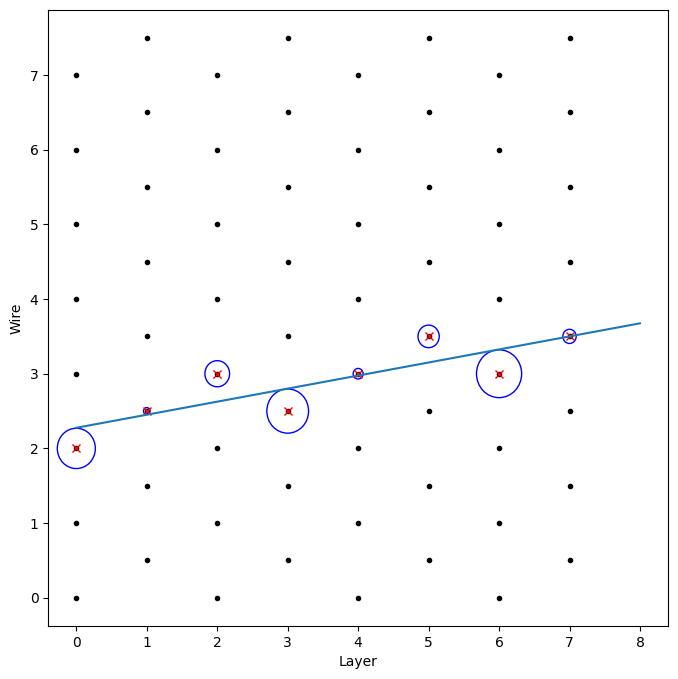

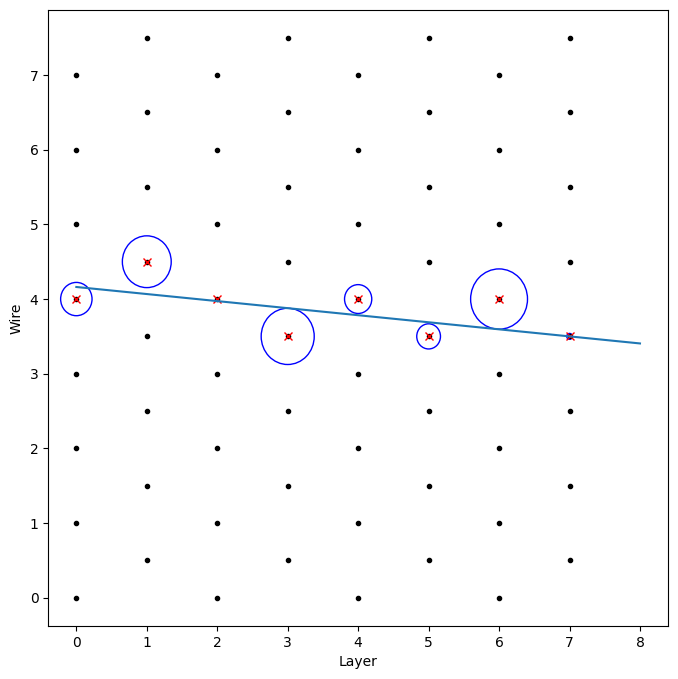

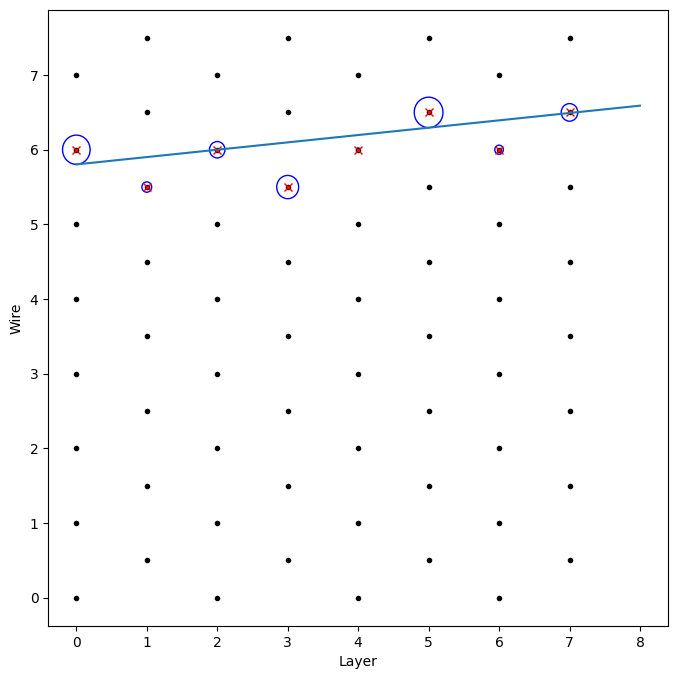

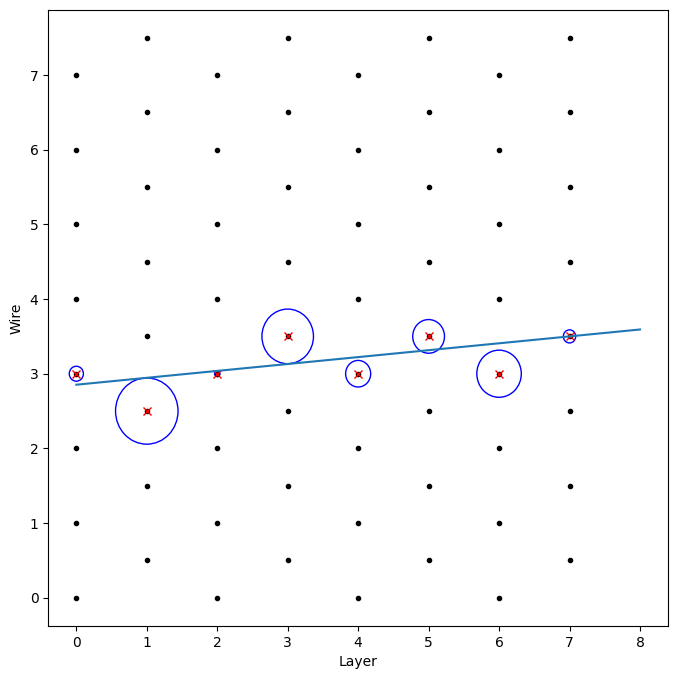

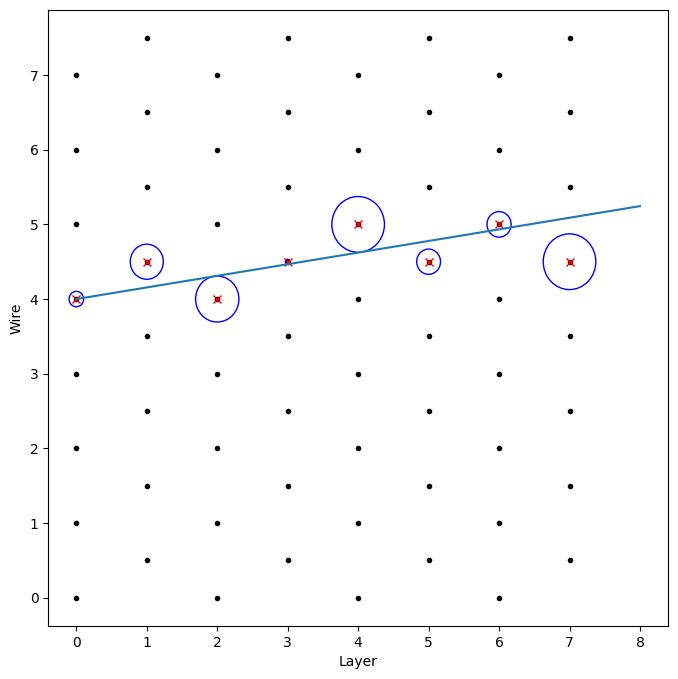

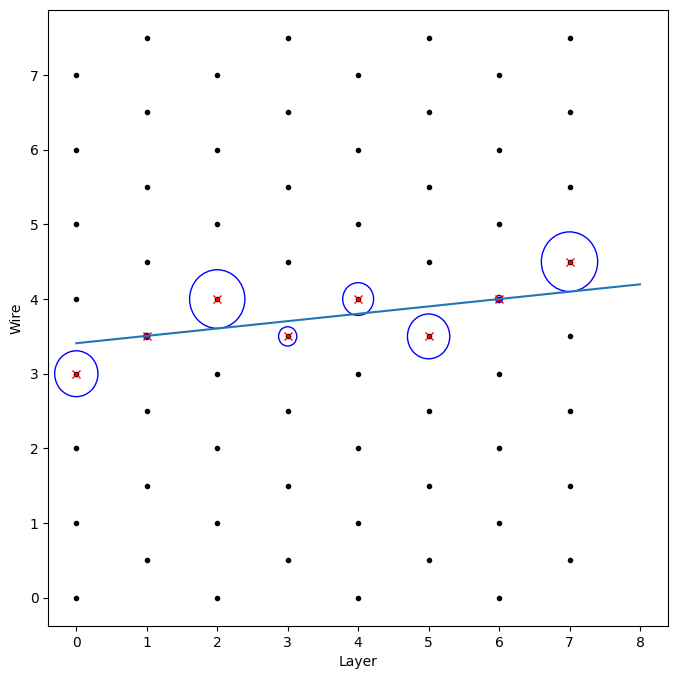

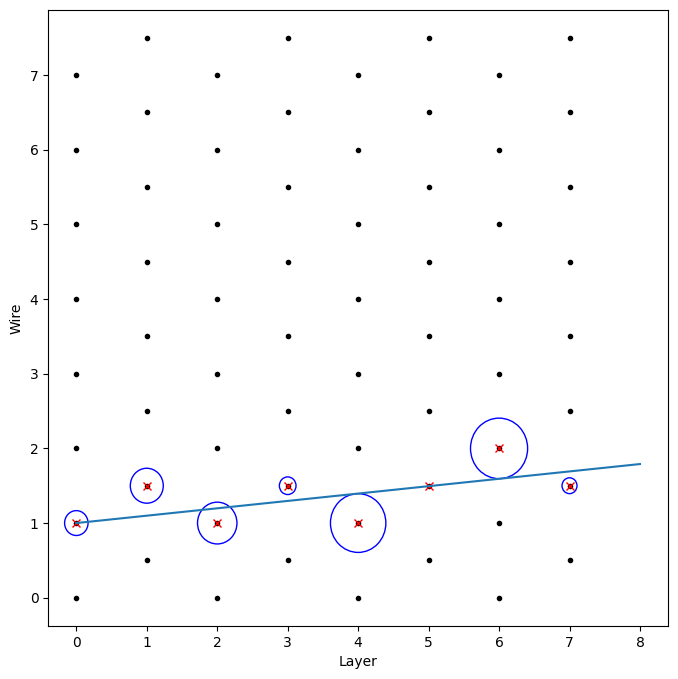

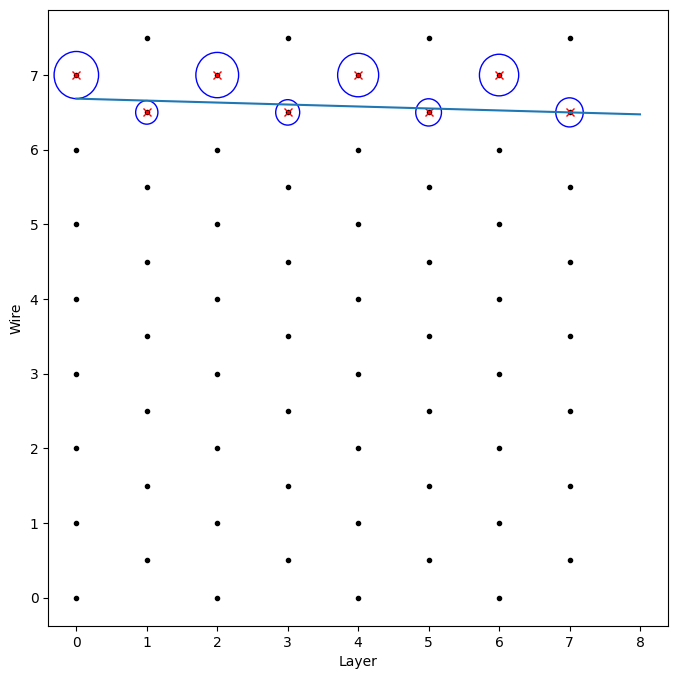

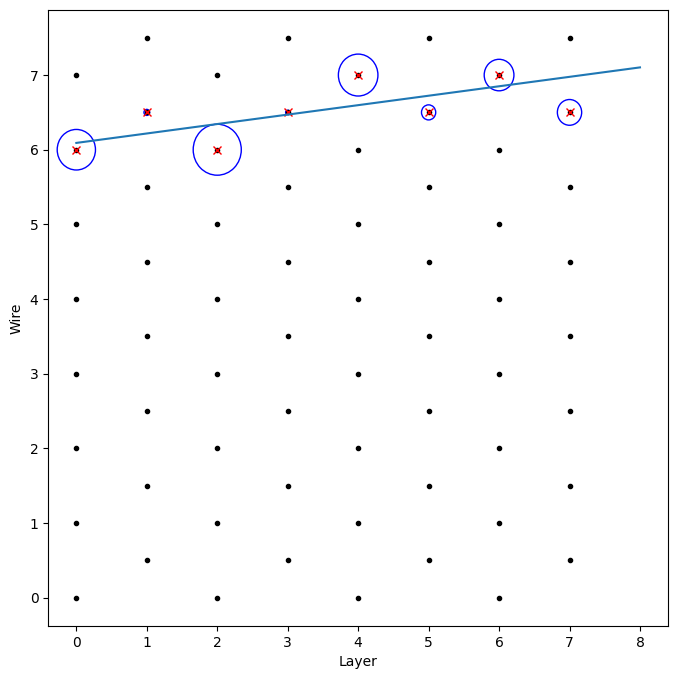

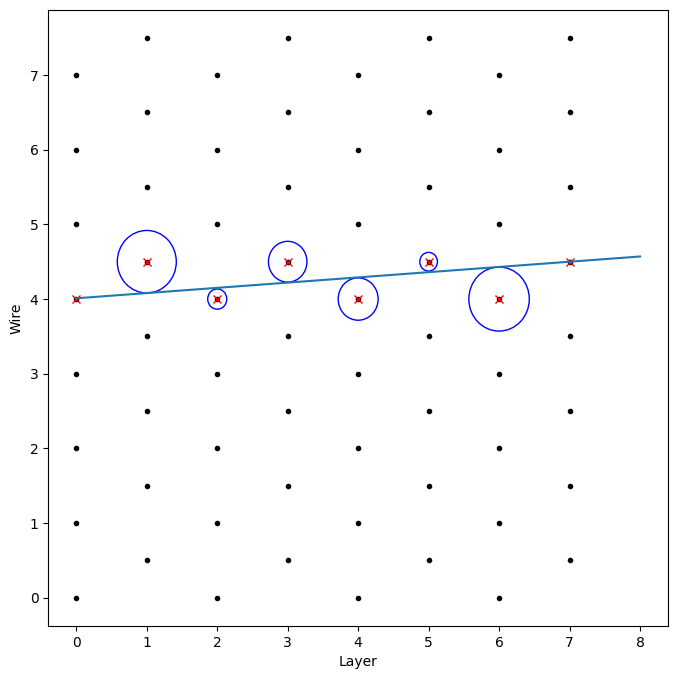

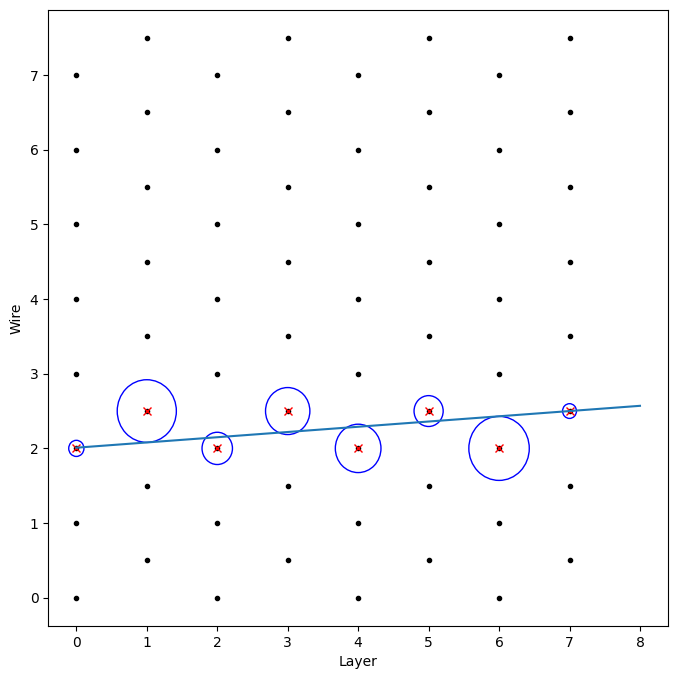

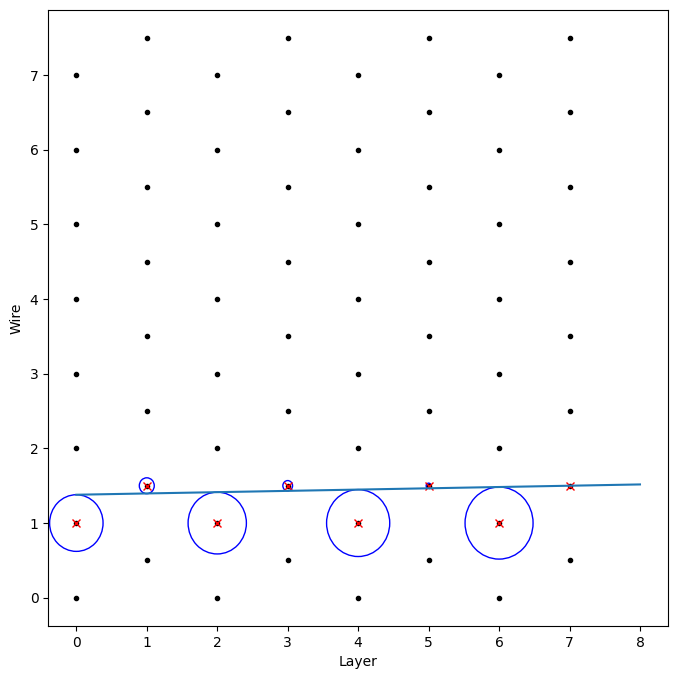

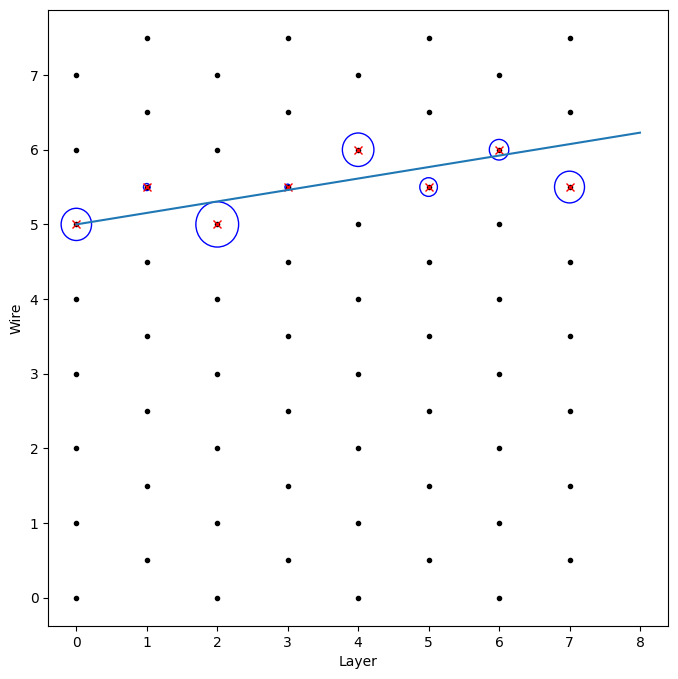

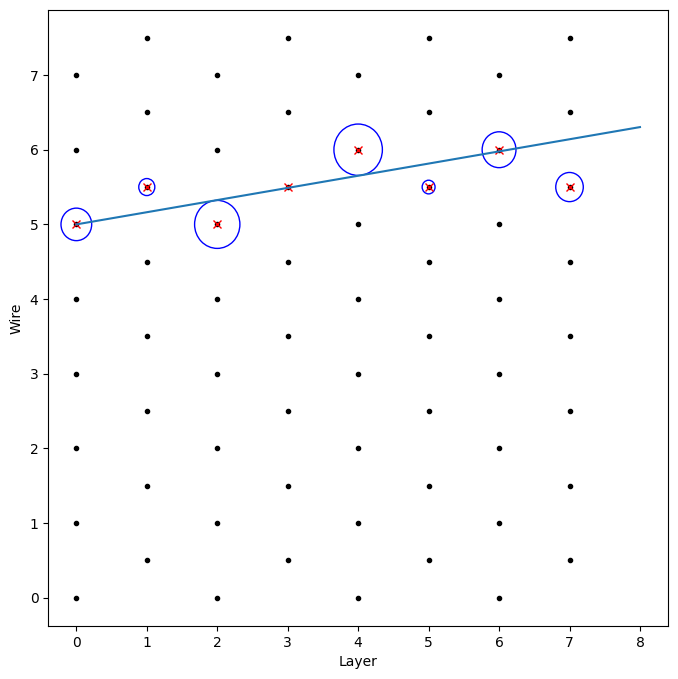

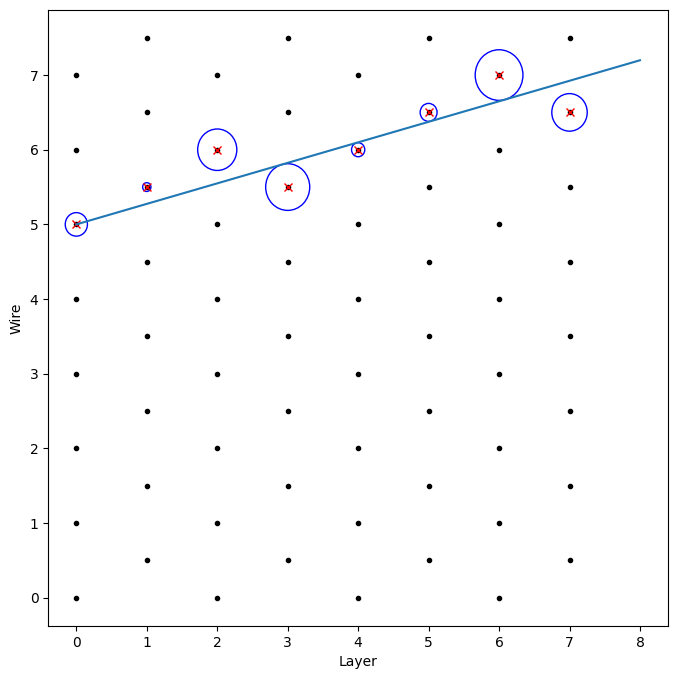

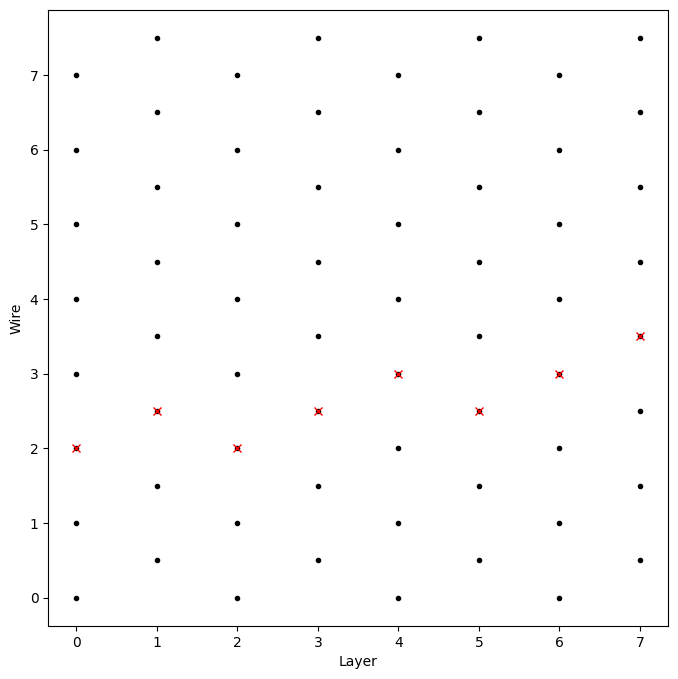

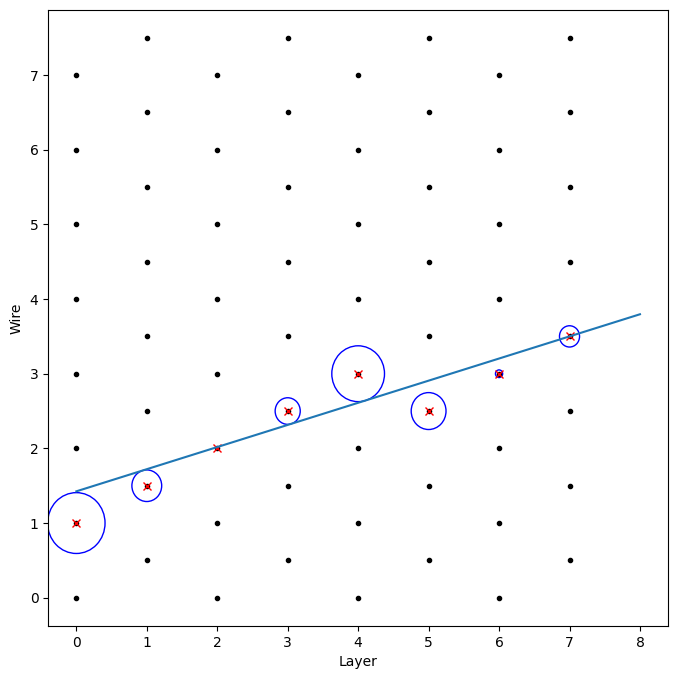

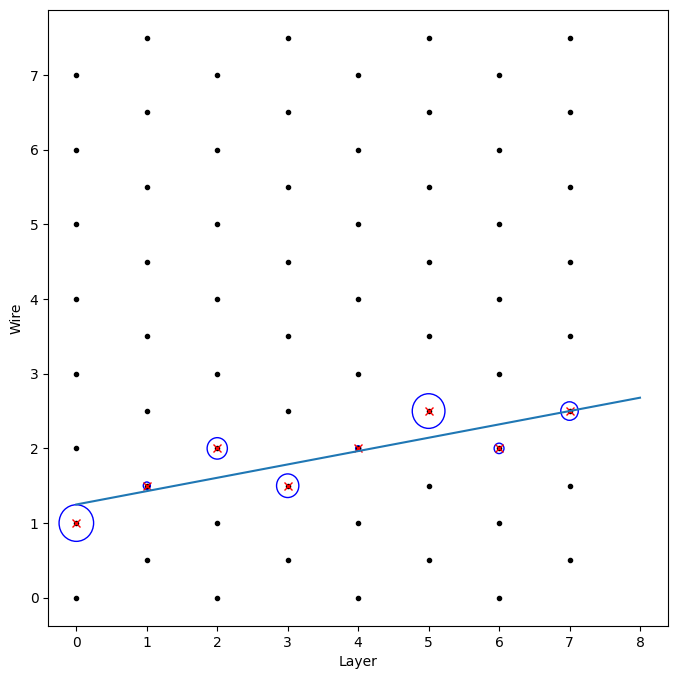

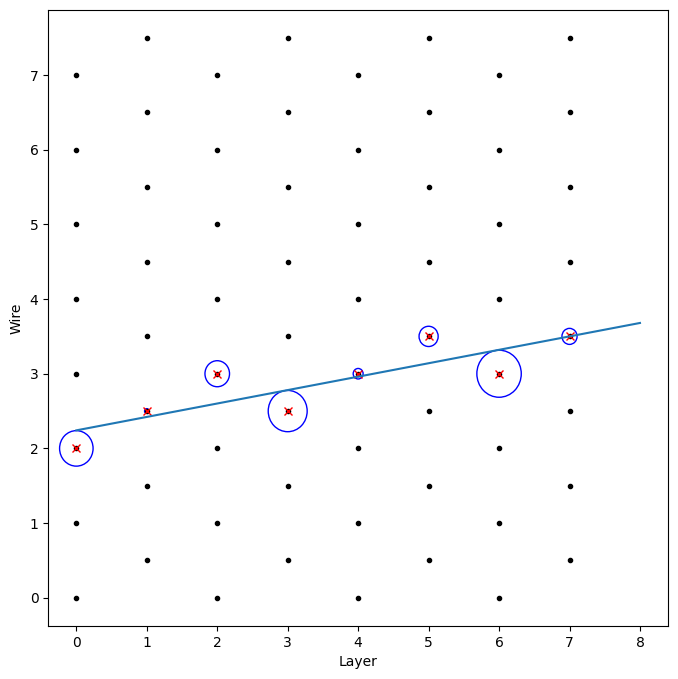

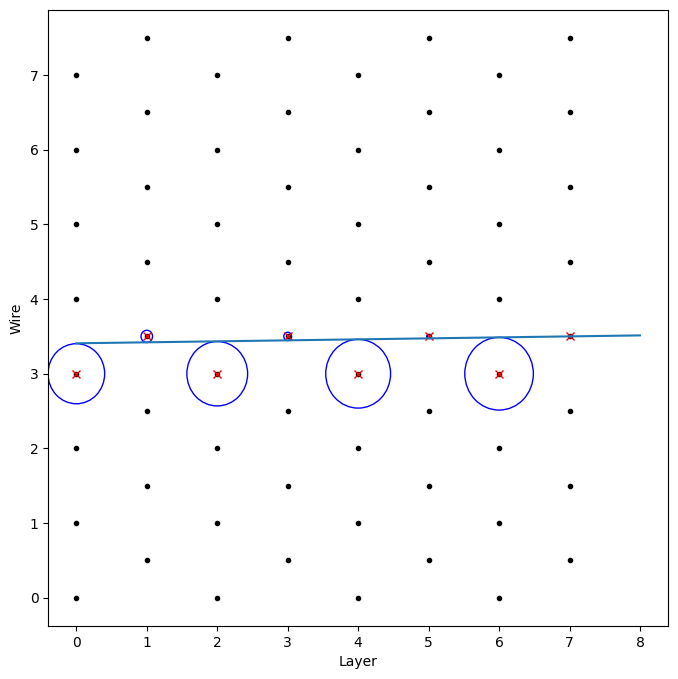

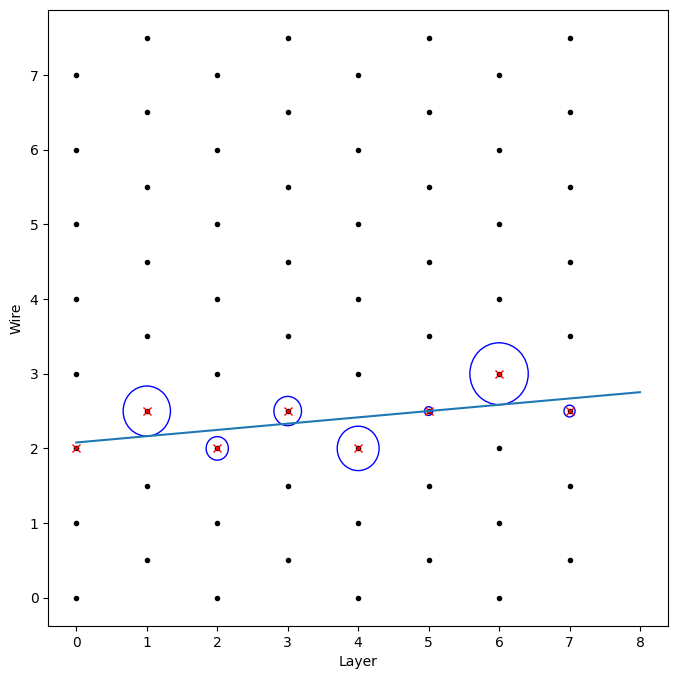

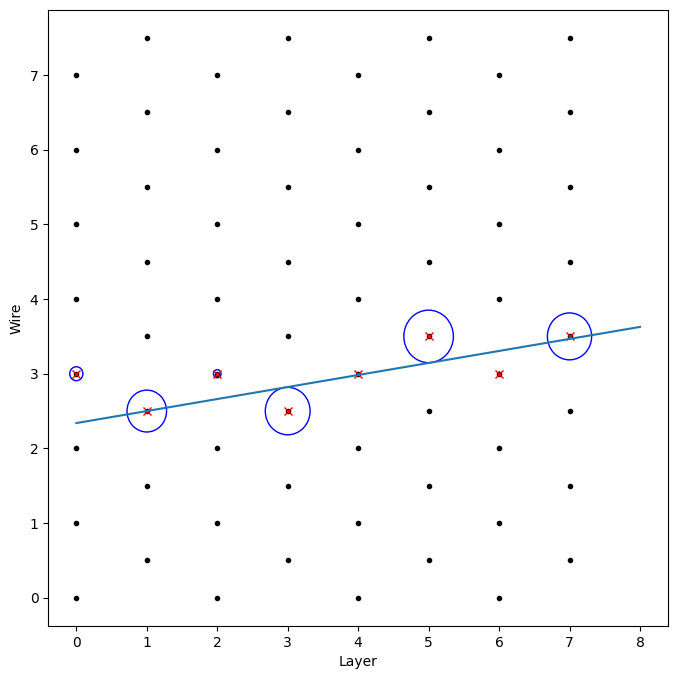

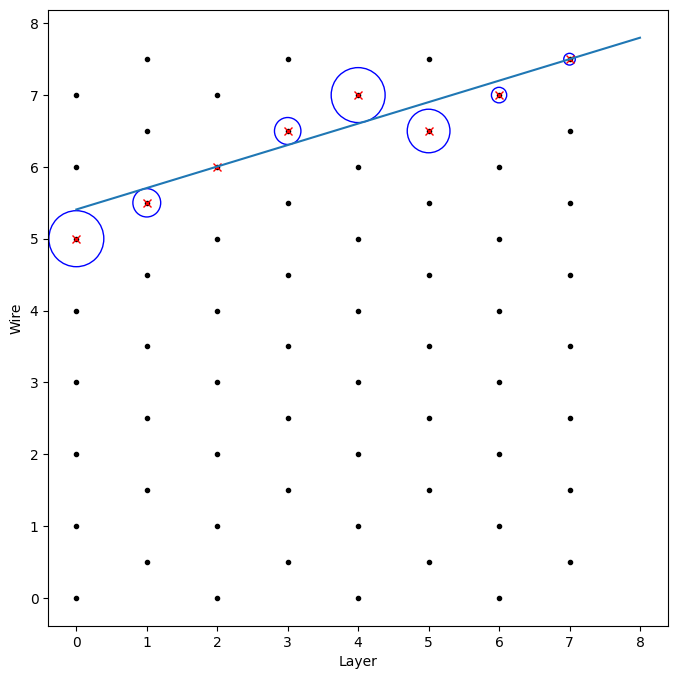

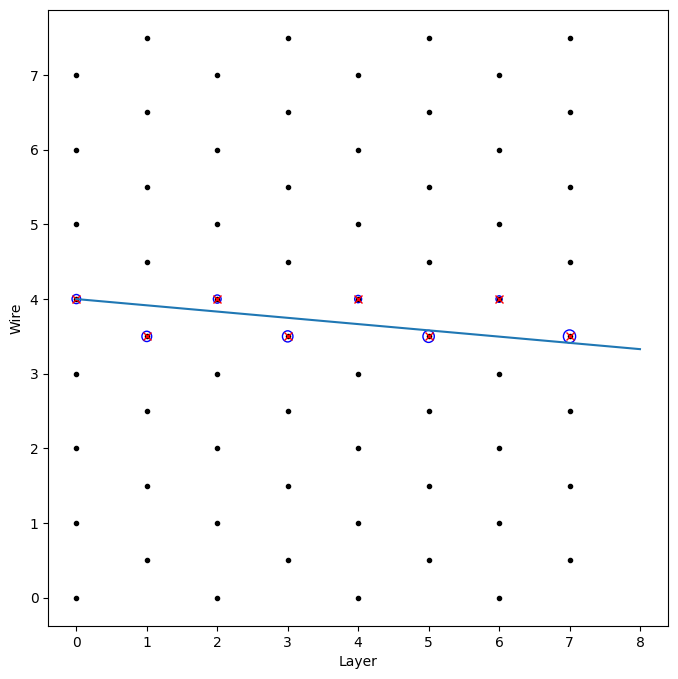

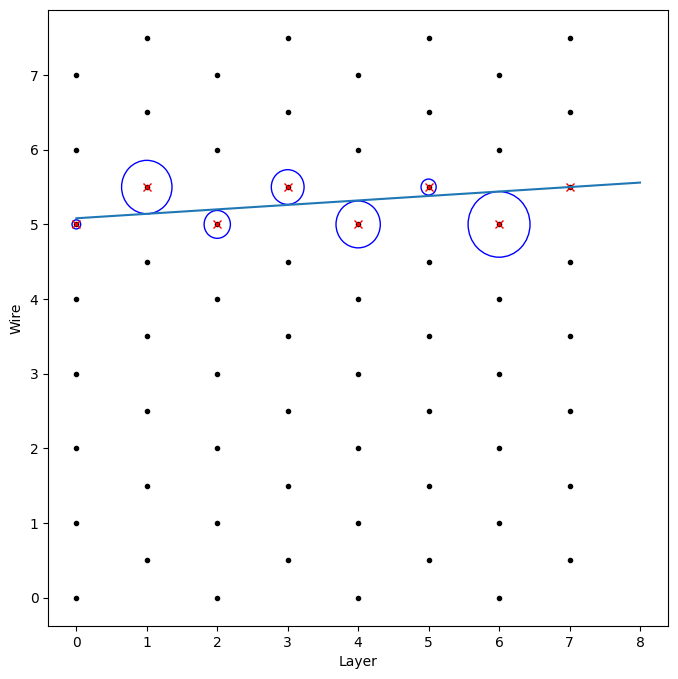

In [40]:
for i in range(25):
    e = event(i, "../data/manytracks.raw")
    run(e)
    e.plot()

## Optimisation ideas
* Seems to be sort of degenerate solutions - is this generally the case?
* better loss function - square it so no -ves?
* GIVE IT BOUNDS
    * set a min size of v


In [19]:
# Uncertainty on the optimisation
# We can get the hessian from the optimisation

# or not - might need to use a different method
for r in res_arr:
    print(r.x)
    print(r.hess)

NameError: name 'res_arr' is not defined